In [44]:
from google.colab import files
uploaded = files.upload()



Saving kaggle.json to kaggle (1).json


In [60]:
import os
os.listdir("/content")
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [46]:
!kaggle datasets download -d atikaakter11/brain-tumor-segmentation-dataset


Dataset URL: https://www.kaggle.com/datasets/atikaakter11/brain-tumor-segmentation-dataset
License(s): MIT
brain-tumor-segmentation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
!unzip brain-tumor-segmentation-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0315.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0316.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0317.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0320.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0321.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0322.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0324.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0325.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0326.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0327.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0332.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0334.jpg  
  inflating: Brain Tumor Segmentation Dataset/image/3/Tr-pi_0335.jpg  
  inflating: Brain Tumor S

In [48]:
import os

base_path = "data/Brain Tumor Segmentation Dataset"

os.listdir(base_path)


['mask', 'image']

In [49]:
import os
os.listdir("data")
image_path = os.path.join(base_path, "image")
mask_path = os.path.join(base_path, "mask")

In [50]:
import os

def get_all_files(folder):
    """
    Recursively get all files in subfolders of a folder.
    Returns a list of full file paths.
    """
    files_list = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.png', '.jpg')):
                files_list.append(os.path.join(root, file))
    return sorted(files_list)  # sort for consistency

image_folder = '/content/data/Brain Tumor Segmentation Dataset/image/'
mask_folder = '/content/data/Brain Tumor Segmentation Dataset/mask/'
output_folder = '/content/segmented/'

os.makedirs(output_folder, exist_ok=True)

image_files = get_all_files(image_folder)
mask_files = get_all_files(mask_folder)

print(f"Total images: {len(image_files)}")
print(f"Total masks: {len(mask_files)}")

Total images: 4237
Total masks: 4239


In [51]:
class_ids = ['0', '1', '2', '3']

image_files = []
mask_files = []

for cls in class_ids:
    img_cls_folder = os.path.join(image_folder, cls)
    mask_cls_folder = os.path.join(mask_folder, cls)


    img_files = sorted([os.path.join(img_cls_folder, f) for f in os.listdir(img_cls_folder) if f.endswith(('.png', '.jpg'))])
    mask_files_cls = sorted([os.path.join(mask_cls_folder, f) for f in os.listdir(mask_cls_folder) if f.endswith(('.png', '.jpg'))])


    if len(mask_files_cls) > len(img_files):
        mask_files_cls = mask_files_cls[:len(img_files)]

    image_files.extend(img_files)
    mask_files.extend(mask_files_cls)

print(f"Total images collected: {len(image_files)}")
print(f"Total masks collected: {len(mask_files)}")

Total images collected: 4237
Total masks collected: 4237


In [52]:
import cv2
import numpy as np
from skimage.filters import threshold_sauvola
from tqdm import tqdm
import random


In [53]:
def dice(pred, gt):
    intersection = np.sum(pred * gt)
    return (2 * intersection) / (np.sum(pred) + np.sum(gt) + 1e-6)

def jaccard(pred, gt):
    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection
    return intersection / (union + 1e-6)


In [54]:
otsu_dice_scores = []
sauvola_dice_scores = []
otsu_jaccard_scores = []
sauvola_jaccard_scores = []


In [55]:
for img_path, mask_path in tqdm(zip(image_files, mask_files), total=len(image_files)):

    img = cv2.imread(img_path, 0)
    gt = cv2.imread(mask_path, 0)

    if img is None or gt is None:
        continue

    gt = cv2.resize(gt, (img.shape[1], img.shape[0]))
    gt = (gt > 127).astype(np.uint8)

    # OTSU
    _, otsu_mask = cv2.threshold(
        img, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    otsu_mask = (otsu_mask > 127).astype(np.uint8)

    # SAUVOLA
    thresh = threshold_sauvola(img, window_size=25,k=0.2)
    sauvola_mask = (img > thresh).astype(np.uint8)

    # Metrics
    otsu_dice_scores.append(dice(otsu_mask, gt))
    sauvola_dice_scores.append(dice(sauvola_mask, gt))

    otsu_jaccard_scores.append(jaccard(otsu_mask, gt))
    sauvola_jaccard_scores.append(jaccard(sauvola_mask, gt))


100%|██████████| 4237/4237 [00:45<00:00, 92.60it/s]


In [56]:
print("FINAL RESULTS ")
print("Otsu Average Dice:", np.mean(otsu_dice_scores))
print("Sauvola Average Dice:", np.mean(sauvola_dice_scores))

print("Otsu Average Jaccard:", np.mean(otsu_jaccard_scores))
print("Sauvola Average Jaccard:", np.mean(sauvola_jaccard_scores))


FINAL RESULTS 
Otsu Average Dice: 0.044329832755901
Sauvola Average Dice: 0.028276355829108896
Otsu Average Jaccard: 0.023865396002533484
Sauvola Average Jaccard: 0.014741144468788136


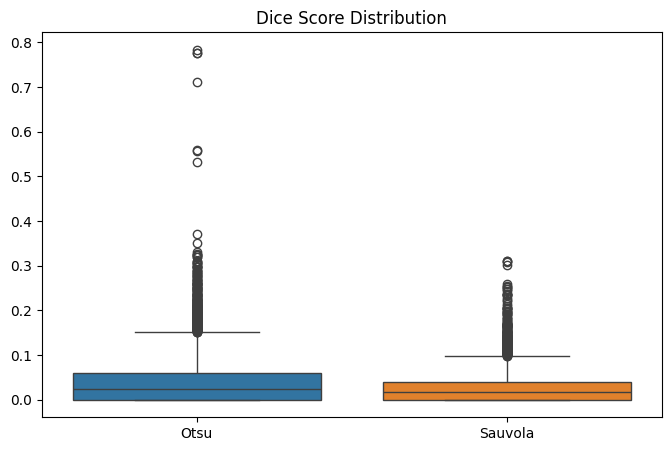

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=[otsu_dice_scores, sauvola_dice_scores])
plt.xticks([0,1], ["Otsu", "Sauvola"])
plt.title("Dice Score Distribution")
plt.show()


In [58]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random


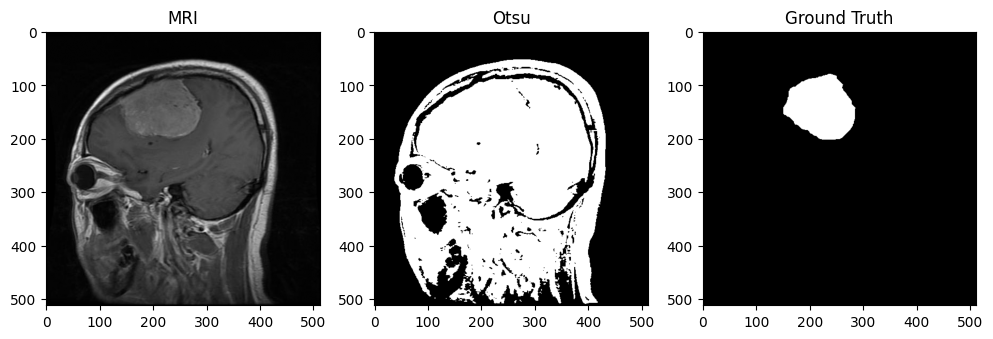

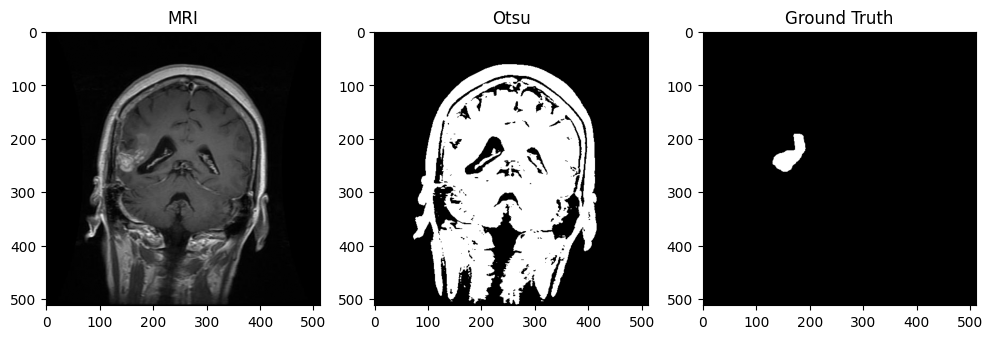

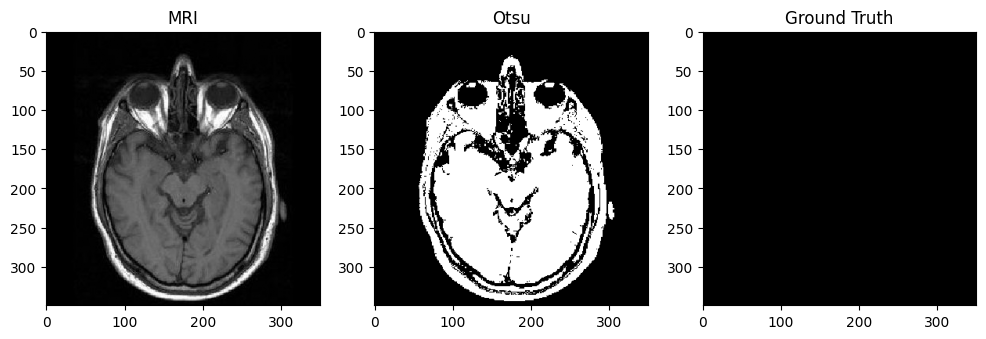

In [59]:
import random

for i in random.sample(range(len(image_files)), 3):

    img = cv2.imread(image_files[i], 0)
    gt = cv2.imread(mask_files[i], 0)
    gt = cv2.resize(gt, (img.shape[1], img.shape[0]))
    gt = (gt > 127).astype(np.uint8)

    _, otsu_mask = cv2.threshold(
        img, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    otsu_mask = (otsu_mask > 127).astype(np.uint8)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title("MRI")

    plt.subplot(1,3,2)
    plt.imshow(otsu_mask, cmap='gray')
    plt.title("Otsu")

    plt.subplot(1,3,3)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")

    plt.show()


